# Lasso regression in Python

## Basics


*This tutorial is mainly based on the excellent book ["An Introduction to Statistical Learning"](https://www.statlearning.com/) from James et al. (2021), the scikit-learn documentation about [regressors with variable selection](https://scikit-learn.org/stable/modules/classes.html#regressors-with-variable-selection) as well as Python code provided by Jordi Warmenhoven in this [GitHub repository](https://nbviewer.org/github/JWarmenhoven/ISL-python/blob/master/Notebooks/Chapter%206.ipynb).*

Lasso regression relies upon the linear regression model but additionaly performs a so called `L1 regularization`, which is a process of introducing additional information in order to prevent overfitting. As a consequence, we can fit a model containing all possible predictors and use lasso to perform variable selection by using a technique that constrains or regularizes the coefficient estimates (it shrinks the coefficient estimates towards zero). In particular, the minimization objective does not only include the residual sum of squares (RSS) - like in the OLS regression setting - but also the sum of the absolute value of coefficients.

The residual sum of squares (RSS) is calculated as follows:

$$ RSS = \sum_{i=1}^{n} (y_i - \hat{y_i})^2 $$

This formula can be stated as:

$$ RSS = \sum_{i=1}^{n} \bigg(y_i - \big( \beta_{0} + \sum_{j=1}^{p} \beta_{j} x_{ij} \big) \bigg)^2  $$

- $n$ represents the number of observations.
- $p$ denotes the number of variables that are available in the dataset.
- $x_{ij}$ represents the value of the jth variable for the ith observation, where i = 1, 2, . . ., n and j = 1, 2, . . . , p.

In the lasso regression, the minimization objective becomes:

$$ \sum_{i=1}^{n} \bigg(y_i - \big( \beta_{0} + \sum_{j=1}^{p} \beta_{j} x_{ij} \big) \bigg)^2 + \lambda \sum_{j=1}^{p} |\beta_j|   $$

which equals:

$$RSS + \lambda \sum_{j=1}^{p} |\beta_j|  $$

$\lambda$ can take various values:

  - $\lambda$ = 0: Same coefficients as least squares linear regression
  - $\lambda$ = ∞: All coefficients are zero
  - 0 < $\lambda$ < ∞: coefficients are between 0 and that of least squares linear regression

Lasso regression’s advantage over least squares linear regression is rooted in the bias-variance trade-off. As $\lambda$ increases, the flexibility of the lasso regression fit decreases, leading to decreased variance but increased bias. This procedure is more restrictive in estimating the coefficients and - depending on your value of $\lambda$ - may set a number of them to exactly zero. This means in the final model the response variable will only be related to a small subset of the predictors—namely, those with nonzero coeffcient estimates. Therefore, selecting a good value of $\lambda$ is critical.

## Data

We illustrate the use of lasso regression on a data frame called "Hitters" with 20 variables and 322 observations of major league players (see [this documentation](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) for more information about the data). We want to predict a baseball player’s salary on the basis of various statistics associated with performance in the previous year.

### Import

In [100]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/Hitters.csv")

In [101]:
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

### Missing values

Note that the salary is missing for some of the players:

In [102]:
print(df.isnull().sum())

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64


In [103]:
# drop missing cases
df = df.dropna()

### Dummy variables

Since we will use the lasso algorithm from scikit learn, we need to encode our categorical features as a one-hot numeric array (dummy variables):

In [104]:
dummies = pd.get_dummies(df[['League', 'Division','NewLeague']])

In [105]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6 KB


In [106]:
print(dummies.head())

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
1         0         1           0           1            0            1
2         1         0           0           1            1            0
3         0         1           1           0            0            1
4         0         1           1           0            0            1
5         1         0           0           1            1            0


### Create label and features

In [107]:
# label
y = df['Salary']

# Drop the column with the outcome variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Create the features
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8  
dtypes: float

### Split data

Split the data set into train and test set with the first 75% of the data for training and the remaining for testing.

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [109]:
X_train.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
61,155.0,44.0,6.0,21.0,23.0,15.0,16.0,6631.0,1634.0,98.0,698.0,661.0,777.0,53.0,88.0,3.0,1,0,1
149,210.0,70.0,13.0,32.0,51.0,28.0,15.0,4040.0,1130.0,97.0,544.0,462.0,551.0,0.0,0.0,0.0,0,0,0
232,313.0,83.0,9.0,43.0,41.0,30.0,14.0,5885.0,1543.0,104.0,751.0,714.0,535.0,58.0,141.0,23.0,1,1,1
216,258.0,60.0,8.0,28.0,33.0,18.0,3.0,638.0,170.0,17.0,80.0,75.0,36.0,358.0,32.0,8.0,0,1,0
293,559.0,141.0,2.0,48.0,61.0,73.0,8.0,3162.0,874.0,16.0,421.0,349.0,359.0,352.0,414.0,9.0,1,0,1


### Standardization

Lasso assumes that all numerical features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

This means it is important to standardize our features. We do this by subtracting the mean from our observations and then dividing the difference by the standard deviation. The so called standard score z for an observation x is calculated as:

$$z = \frac{(x- \bar x)}{s}$$

where:

- x is an observation in a feature
- $\bar x$ is the mean of that feature
-  s is the standard deviation of that feature.

To avoid [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)), the standardization should always be performed after the data splitting. Furthermore, we use the mean and standard deviation of the features in the training data to perform the standardization in the corresponding test data.

In [110]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train) # make scaler with training data

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [112]:
X_train

array([[-1.68963526, -1.42804651, -0.66844475, ...,  1.01534617,
        -1.01534617,  1.06831847],
       [-1.30999902, -0.83563911,  0.15311079, ..., -0.98488578,
        -1.01534617, -0.93605047],
       [-0.5990439 , -0.5394354 , -0.31634952, ...,  1.01534617,
         0.98488578,  1.06831847],
       ...,
       [ 1.49240661,  1.28335661,  1.79622186, ..., -0.98488578,
         0.98488578, -0.93605047],
       [-1.44804856, -1.38247671, -1.13790506, ..., -0.98488578,
         0.98488578, -0.93605047],
       [-1.62061049, -1.54197102, -1.13790506, ..., -0.98488578,
         0.98488578,  1.06831847]])

## Model

Next, we use scikit learn to apply lasso regression on the training set with the regularization parameter set to 0.5. Note that in the function the regularization parameter is called alpha (not lambda).

In [113]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)

Lasso(alpha=0.5)

We print the $R^2$-score for the training and test set.

In [114]:
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

Lasso Regression: R squared score on training set 59.98
Lasso Regression: R squared score on test set 32.06


MSE for the training and test set.

In [118]:
from sklearn.metrics import mean_squared_error

pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 78571.03
MSE test set 149346.25


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


''

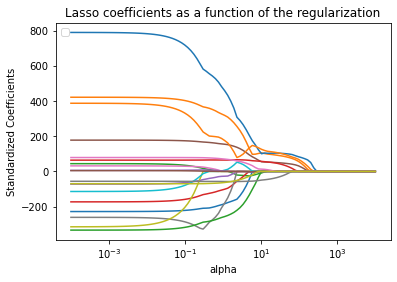

In [140]:
alphas = 10**np.linspace(4,-4,100)*0.5
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of the regularization');

Remember that When λ = 0, then the lasso gives the least squares fit, and when λ becomes large, the lasso gives the null model in which all coefficient estimates equal zero. Moving from left to right in our plot, we observe that at first the lasso results in a model that contains only the rating predictor. Then student and limit enter the model almost simultaneously, shortly followed by income. Eventually, the remaining variables enter the model. Hence, depending on the value of λ, the lasso can produce a model involving any number of variables. In contrast, ridge regression will always include all of the variables in the model, although the magnitude of the coeﬃcient estimates will depend on λ.

### Tune lambda

#### Fit models

In [120]:
from sklearn.linear_model import LassoCV

# Define lasso
model = LassoCV(cv=5, alphas=None ,random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [122]:
# Show best alpha
model.alpha_

19.842402978097798

In [ ]:
# Set best alpha
lasso.set_params(alpha=model.alpha_)


lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

Next, we use the Akaike information criterion (AIC), the Bayes Information criterion (BIC) and cross-validation to select an optimal value of the regularization parameter alpha of the Lasso estimator. This example is based on the 

Apply the **Lasso regression** on the training set with the following **λ parameters: (0.001, 0.01, 0.1, 0.5, 1, 2, 10)**. 

Evaluate the $R^2$ score for all the models you obtain on both the train and test sets.

In [69]:
model.get_params(deep=True)

{'alphas': None,
 'copy_X': True,
 'cv': 10,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': False,
 'positive': False,
 'precompute': 'auto',
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

Lasso model selection: Cross-Validation / AIC / BIC¶
 https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py

(0.18577197244029905,
 370.50859203659064,
 38159.46775445403,
 360599.85047898587)

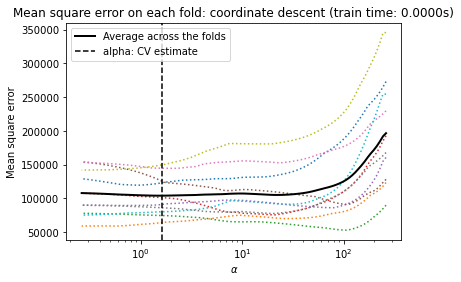

In [70]:
import time

# This is to avoid division by zero while doing np.log10
EPSILON = 1e-4

t1 = time.time()
t_lasso_cv = time.time() - t1

# Display results
plt.figure()
#ymin, ymax = 2300, 3800
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ":")
plt.plot(
    model.alphas_ + EPSILON,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_ + EPSILON, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.title(
    "Mean square error on each fold: coordinate descent (train time: %.4fs)"
    % t_lasso_cv
)
plt.axis("tight")
#plt.ylim(ymin, ymax)

According to Olivier Grisel, Gael Varoquaux, Alexandre Gramfort
The object solves the same problem as the LassoCV object. However, unlike the LassoCV, it find the relevant alphas values by itself. In general, because of this property, it will be more stable. However, it is more fragile to heavily multicollinear datasets.

It is more efficient than the LassoCV if only a small number of features are selected compared to the total number, for instance if there are very few samples compared to the number of features.





/Users/jankirenz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=1.004e+01, previous alpha=9.743e+00, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/Users/jankirenz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=1.004e+01, previous alpha=9.743e+00, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


Text(0.5, 1.0, 'Information-criterion for model selection (training time 0.004s)')

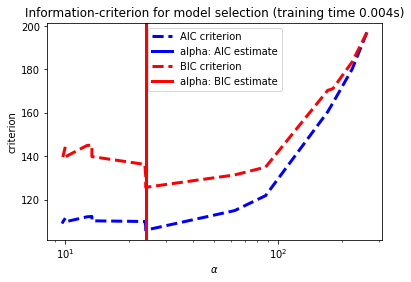

In [74]:
from sklearn.linear_model import LassoLarsCV


model_bic = LassoLarsIC(criterion="bic", normalize=False)
t1 = time.time()
model_bic.fit(X_train, y_train)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion="aic", normalize=False)
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(
        model.alphas_ + EPSILON,
        criterion_,
        "--",
        color=color,
        linewidth=3,
        label="%s criterion" % name,
    )
    plt.axvline(
        model.alpha_ + EPSILON,
        color=color,
        linewidth=3,
        label="alpha: %s estimate" % name,
    )
    plt.xlabel(r"$\alpha$")
    plt.ylabel("criterion")


plt.figure()
plot_ic_criterion(model_aic, "AIC", "b")
plot_ic_criterion(model_bic, "BIC", "r")
plt.legend()
plt.title("Information-criterion for model selection (training time %.3fs)" % t_bic)


/Users/jankirenz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=1.004e+01, previous alpha=9.743e+00, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/Users/jankirenz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=1.004e+01, previous alpha=9.743e+00, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


Text(0.5, 1.0, 'Information-criterion for model selection (training time 0.045s)')

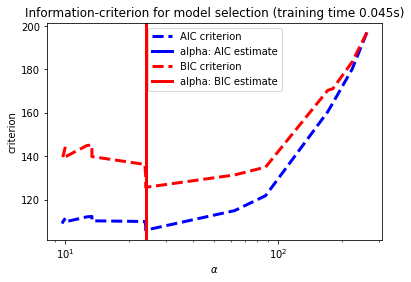

In [72]:
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC


model_bic = LassoLarsIC(criterion="bic", normalize=False)
t1 = time.time()
model_bic.fit(X_train, y_train)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion="aic", normalize=False)
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(
        model.alphas_ + EPSILON,
        criterion_,
        "--",
        color=color,
        linewidth=3,
        label="%s criterion" % name,
    )
    plt.axvline(
        model.alpha_ + EPSILON,
        color=color,
        linewidth=3,
        label="alpha: %s estimate" % name,
    )
    plt.xlabel(r"$\alpha$")
    plt.ylabel("criterion")


plt.figure()
plot_ic_criterion(model_aic, "AIC", "b")
plot_ic_criterion(model_bic, "BIC", "r")
plt.legend()
plt.title("Information-criterion for model selection (training time %.3fs)" % t_bic)


In [54]:
from sklearn.linear_model import lasso_path, enet_path

eps = 5e-3  # the smaller it is the longer is the path


print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, eps=eps)

Computing regularization path using the lasso...


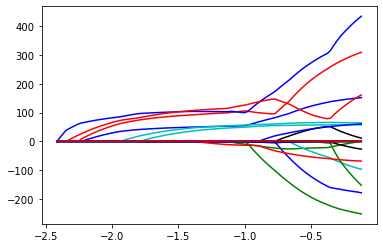

In [60]:
from itertools import cycle

plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)

In [72]:
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

In [73]:
# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

In [74]:
# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

#### Plot result

Plot all values for both data sets (train and test $R^2$-values) as a function of λ. Note that we use the index of the values at the x-axis, not the values themselves. 

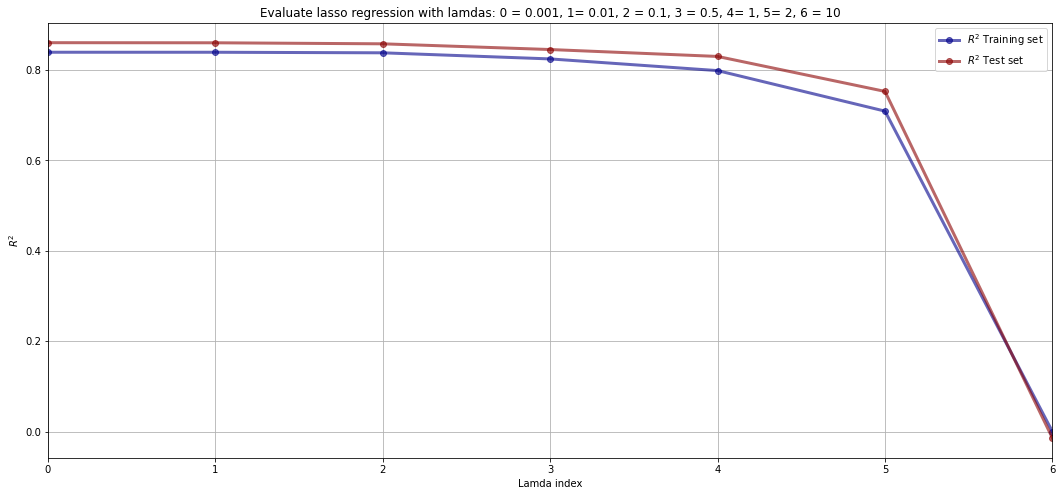

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18, 8))

plt.plot(train_r_squared, 'o-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'o-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)

plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

#### Identify best lambda

Store your test data results in a DataFrame and indentify the lambda where the $R^2$ has it's **maximum value** in the **test data**. 

In [76]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    86.069153
lambda        0.001000
Name: 0, dtype: float64

Fit a Lasso model with this lambda parameter (use the training data) and obtain the corresponding **regression coefficients**. 


In [77]:
reg_best = Lasso(alpha = 0.1)
reg_best.fit(X_train, y_train)
reg_best.coef_

array([-3.59692164e-01, -1.14969745e+00, -3.14657390e-03, -3.38035561e+00,
       -0.00000000e+00,  3.73181500e-01,  7.53577777e-01])

Obtain the **mean squared error** for the test data of this model (module: `from sklearn.metrics import mean_squared_error`)

In [78]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, reg_best.predict(X_test))

4.13967603869106

## Tune with k-fold cross validation

Evaluate the performance of a Lasso regression for different regularization parameters λ using **5-fold cross validation** on the training set (module: `from sklearn.model_selection import cross_val_score`) and plot the cross-validation (CV) $R^2$ scores of the training and test data as a function of λ.


 We use the following lambda parameters:

In [79]:
l_min = 0.05
l_max = 0.2
l_num = 20
lambdas = np.linspace(l_min,l_max, l_num)

In [80]:
# data preparation
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

pred_num = X.shape[1]
coeff_a = np.zeros((l_num, pred_num))

In [81]:
# models
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=5, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

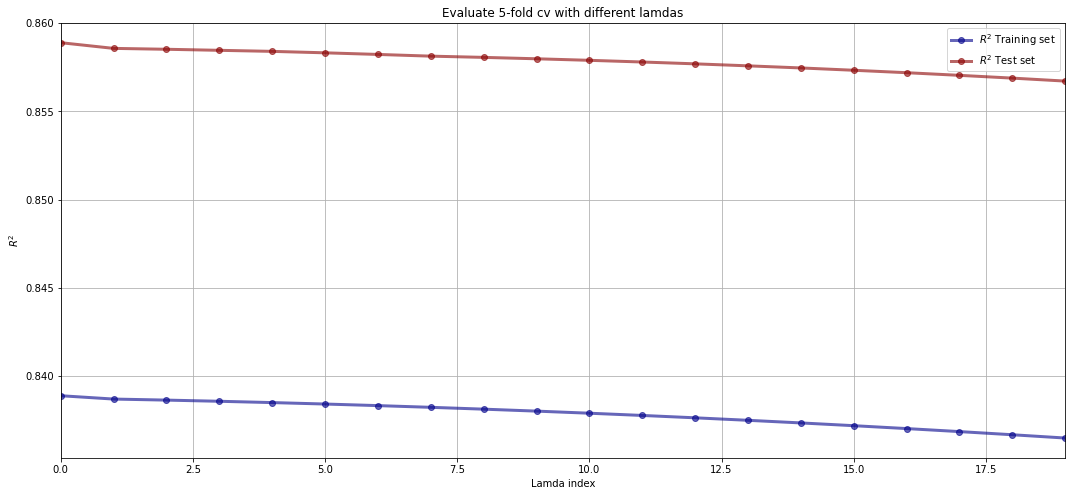

In [82]:
# Plotting
plt.figure(figsize=(18, 8))

plt.plot(train_r_squared, 'o-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'o-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)

plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 19)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

Finally, store your test data results in a DataFrame and identify the lambda where the $R^2$ has it's **maximum value** in the **test data**. 

In [83]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    85.889304
lambda        0.050000
Name: 0, dtype: float64

Fit a Lasso model with this lambda parameter (use the training data) and obtain the corresponding **regression coefficients**. Furthermore, obtain the **mean squared error** for the test data of this model (module: `from sklearn.metrics import mean_squared_error`)

In [84]:
# Best Model
reg_best = Lasso(alpha = 0.05)
reg_best.fit(X_train, y_train)

Lasso(alpha=0.05)

In [85]:
mean_squared_error(y_test, reg_best.predict(X_test))

4.11925090254981

In [86]:
reg_best.coef_

array([-0.38405539, -1.08687731, -0.04867365, -3.41242241, -0.02807974,
        0.42234148,  0.79308801])